In [28]:
import json
import matplotlib.pyplot as plt
import pandas as pd
from configparser import ConfigParser
from pathlib import Path
from IPython.display import display, Markdown


## Load game configuration

In [29]:
ROOT = Path('..').resolve()

"""Identifies the config file, loads it and returns a config dictionary."""
# Select configuration file: config.cfg, config-default.cfg, first of any other *.cfg    
if (ROOT/'config.cfg').is_file():
    p2config = ROOT / 'config.cfg'
elif (ROOT/'config-default.cfg').is_file():
    p2config = ROOT / 'config-default.cfg'
elif len(list(ROOT.glob('config*.cfg'))) > 0:
    p2config = list(ROOT.glob('config*.cfg'))[0]
else:
    raise FileNotFoundError('No configuration file found. Should be a *.cfg file')

cfg = ConfigParser()
cfg.read(p2config)
config_dict = {k:v for k,v in cfg['DEFAULT'].items()}
numerical_values = ['duration-minutes']
for k in numerical_values:
    config_dict[k] = int(config_dict[k])

p2games = ROOT/ f"config/{config_dict['cfg-folder']}/{config_dict['games']}"
p2cast = ROOT/ f"config/{config_dict['cfg-folder']}/{config_dict['cast']}"
p2prompts = ROOT/ f"config/{config_dict['cfg-folder']}/{config_dict['prompts']}"

with open(p2games, 'r') as fp: games = json.load(fp)
with open(p2cast, 'r') as fp: cast = sorted([l.rstrip('\n') for l in fp.readlines()])

## Game and Hosting exclusion summary

### Game Exclusions

In [30]:
game_exlusion = {g['name']: g['exclude'] for g in games.values()}
df = pd.DataFrame(index=game_exlusion.keys(),columns=cast).fillna(0)
for idx, excl in game_exlusion.items():
    excluded_cast = list(set(cast).intersection(set(excl)))
    df.loc[idx, excluded_cast] = 1
game_exlusion_summary = df.sum(axis=0)

display(Markdown('### Game Exclusions Summary:'))
display(game_exlusion_summary)
display(Markdown('### Game Exclusions:'))
display(df)

### Game Exclusions Summary:

Chris       0
Etienne     0
Grace       0
Haili       6
Knick       3
Lenny       5
Punk       19
Xu          3
Yirong      1
dtype: int64

### Game Exclusions:

,Chris,Etienne,Grace,Haili,Knick,Lenny,Punk,Xu,Yirong
A Date with Me,0,0,0,0,0,0,1,0,0
Double Reverse Alphabet,0,0,0,1,0,0,1,1,0
Emotion Roller Coaster,0,0,0,0,0,0,1,0,0
Everyone Dies,0,0,0,1,0,0,1,0,0
Forward Reverse,0,0,0,0,0,1,0,0,0
Genres,0,0,0,0,0,1,1,0,0
Irish Drinking Song,0,0,0,0,0,0,1,1,1
Last Comic Standing,0,0,0,1,0,1,1,0,0
Mutant Debate,0,0,0,0,0,0,1,0,0
One Three Five,0,0,0,0,1,0,1,0,0


In [31]:
host_include = {g['name']: g['host_include'] for g in games.values()}
df = pd.DataFrame(index=host_include.keys(),columns=cast).fillna(0)
for idx, incl in host_include.items():
    hosting_cast = list(set(cast).intersection(set(incl)))
    df.loc[idx, hosting_cast] = 1
game_hosting_summary = df.sum(axis=0)
display(Markdown('### Hosting Inclusions Summary:'))
display(game_hosting_summary)
display(Markdown('### Hosting Inclusions:'))
display(df)

### Hosting Inclusions Summary:

Chris      1
Etienne    3
Grace      1
Haili      0
Knick      3
Lenny      1
Punk       0
Xu         1
Yirong     3
dtype: int64

### Hosting Inclusions:

,Chris,Etienne,Grace,Haili,Knick,Lenny,Punk,Xu,Yirong
A Date with Me,1,1,0,0,0,0,0,0,0
Double Reverse Alphabet,0,0,0,0,0,0,0,0,0
Emotion Roller Coaster,0,0,0,0,0,0,0,0,0
Everyone Dies,0,0,0,0,0,0,0,0,0
Forward Reverse,0,0,0,0,0,0,0,0,0
Genres,0,0,0,0,1,0,0,0,0
Irish Drinking Song,0,0,0,0,0,1,0,0,0
Last Comic Standing,0,0,0,0,0,0,0,0,0
Mutant Debate,0,1,1,0,0,0,0,0,1
One Three Five,0,0,0,0,0,0,0,1,0


## Hosting Exclusions

In [32]:
host_exclude = {g['name']: g['host_exclude'] for g in games.values()}
df = pd.DataFrame(index=host_exclude.keys(),columns=cast).fillna(0)
for idx, excl in host_exclude.items():
    hosting_cast = list(set(cast).intersection(set(excl)))
    df.loc[idx, hosting_cast] = 1
game_hosting_summary = df.sum(axis=0)

display(Markdown('### Hosting Exclusions Summary:'))
display(game_hosting_summary)
display(Markdown('### Hosting Exclusions:'))
display(df)

### Hosting Exclusions Summary:

Chris       1
Etienne     0
Grace       3
Haili      20
Knick       6
Lenny      19
Punk       21
Xu         19
Yirong      0
dtype: int64

### Hosting Exclusions:

,Chris,Etienne,Grace,Haili,Knick,Lenny,Punk,Xu,Yirong
A Date with Me,0,0,0,1,1,1,1,1,0
Double Reverse Alphabet,0,0,0,1,1,1,1,1,0
Emotion Roller Coaster,0,0,0,1,1,1,1,1,0
Everyone Dies,0,0,0,1,1,1,1,1,0
Forward Reverse,0,0,1,1,0,1,1,1,0
Genres,0,0,0,1,0,1,1,1,0
Irish Drinking Song,0,0,0,1,0,0,1,1,0
Last Comic Standing,0,0,0,1,0,1,1,1,0
Mutant Debate,0,0,0,1,1,1,1,1,0
One Three Five,0,0,0,1,0,1,1,0,0


## Plot stats

In [33]:
def plot_boxplot(df, exclusions=None, title=None):

    plt.figure(figsize=(12, 6));
    boxplot = df.plot(
        kind='box', 
        notch=True,
        sym='',
        # title='Average share of games played', 
        color=dict(boxes='green', whiskers='gray', medians='green', caps='gray')
        )
    means = df.mean(axis=0)
    boxplot_stats = df.describe().T
    third_quartiles = boxplot_stats['75%']
    for i, (m, q3) in enumerate(zip(means, third_quartiles)):
        y_pos = 0.01
        plt.annotate(
            f'{m:.2f}', 
            xy=(i + 1, m), 
            xytext=(i + 1, q3+0.01),  # Adjust the offset as needed
            ha='center', 
            color='green',
        )
    
    for i, nb_excl in enumerate(exclusions):
        y_pos = 0.02
        plt.annotate(
            f'{nb_excl}', 
            xy=(i + 1, y_pos), 
            xytext=(i + 1, y_pos),  # Adjust the offset as needed
            ha='center', 
            color='gray'
        )
    
    if title:
        plt.title(title)
    boxplot.set_xlabel('Players')
    boxplot.set_ylabel('Share')
    boxplot.set_ylim(0, 1)

    plt.xticks(rotation=45)
    plt.show()

<Figure size 1200x600 with 0 Axes>

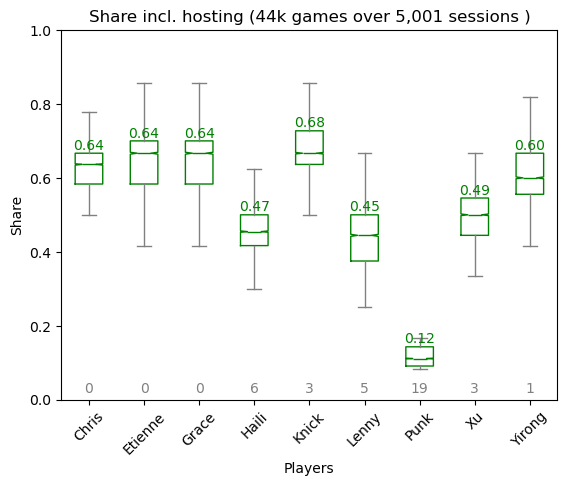

In [34]:
p2stats_w_host = Path('../logs/stats_test_w_host.csv')
if  p2stats_w_host.exists():
    df = pd.read_csv(p2stats_w_host, index_col=0).loc[:, ['Games'] + cast]
    players = list(df.columns)
    players.remove('Games')
    share_w = df.loc[:, players].div(df['Games'], axis=0)
    title = f'Share incl. hosting ({df["Games"].sum()//1000:,d}k games over {df.shape[0]:,d} sessions )'
    plot_boxplot(share_w, exclusions=game_exlusion_summary, title=title)

<Figure size 1200x600 with 0 Axes>

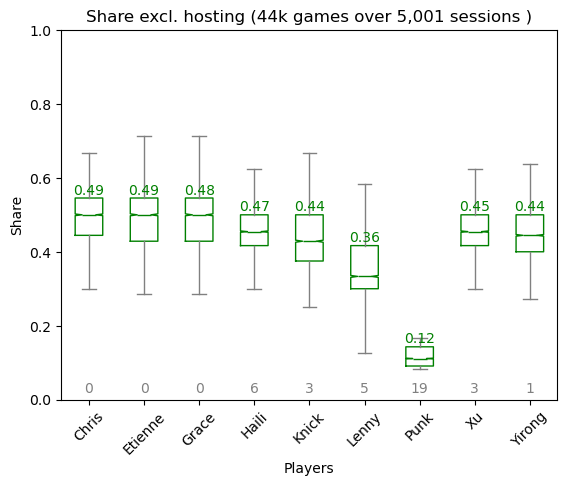

In [35]:
p2stats_wo_host = Path('../logs/stats_test_wo_host.csv')
if p2stats_wo_host.exists():
    df = pd.read_csv(p2stats_wo_host, index_col=0).loc[:, ['Games'] + cast]
    players = list(df.columns)
    players.remove('Games')
    share_wo = df.loc[:, players].div(df['Games'], axis=0)
    title = f'Share excl. hosting ({df["Games"].sum()//1000:,d}k games over {df.shape[0]:,d} sessions )'
    plot_boxplot(share_wo, exclusions=game_exlusion_summary, title=title)